In [ ]:
!unzip signatures.zip

Archive:  signatures.zip
   creating: signatures/
   creating: signatures/full_forg/
  inflating: signatures/full_forg/forgeries_10_1.png  
  inflating: signatures/full_forg/forgeries_10_10.png  
  inflating: signatures/full_forg/forgeries_10_11.png  
  inflating: signatures/full_forg/forgeries_10_12.png  
  inflating: signatures/full_forg/forgeries_10_13.png  
  inflating: signatures/full_forg/forgeries_10_14.png  
  inflating: signatures/full_forg/forgeries_10_15.png  
  inflating: signatures/full_forg/forgeries_10_16.png  
  inflating: signatures/full_forg/forgeries_10_17.png  
  inflating: signatures/full_forg/forgeries_10_18.png  
  inflating: signatures/full_forg/forgeries_10_19.png  
  inflating: signatures/full_forg/forgeries_10_2.png  
  inflating: signatures/full_forg/forgeries_10_20.png  
  inflating: signatures/full_forg/forgeries_10_21.png  
  inflating: signatures/full_forg/forgeries_10_22.png  
  inflating: signatures/full_forg/forgeries_10_23.png  
  inflating: signatur

In [ ]:
import sys
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

import cv2
import time
import itertools
import random

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout, BatchNormalization, MaxPooling2D, Concatenate, Lambda, Flatten, Dense
from keras.models import Model

from keras.initializers import glorot_uniform

from tensorflow.keras.layers import Layer
from keras.regularizers import l2
import tensorflow.keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
path = "/data/"

In [ ]:
img_h, img_w = 280, 280 #155, 220

In [ ]:
dir_list = next(os.walk(path))[1]
dir_list.sort()
print(dir_list)

['full_forg', 'full_org']


In [ ]:
orig_groups, forg_groups = [], []

images = os.listdir(path+dir_list[0])
images.sort()

for i in range(0, len(images), 24):
  person = []
  person.append(path+dir_list[0]+"/"+images[i])
  for j in range(i+1, i+24):
    person.append(path+dir_list[0]+"/"+images[j])
  forg_groups.append(person)

In [ ]:
images = os.listdir(path+dir_list[1])
images.sort()

for i in range(0, len(images), 24):
  person = []
  person.append(path+dir_list[1]+"/"+images[i])
  for j in range(i+1, i+24):
    person.append(path+dir_list[1]+"/"+images[j])
  orig_groups.append(person)

In [ ]:
len(orig_groups), len(forg_groups)

(55, 55)

In [ ]:
orig_lengths = [len(x) for x in orig_groups]
forg_lengths = [len(x) for x in forg_groups]

In [ ]:
print(orig_lengths)

[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]


In [ ]:
orig_train, orig_test = train_test_split(orig_groups, test_size=0.2, random_state=42)
forg_train, forg_test = train_test_split(forg_groups, test_size=0.2, random_state=42)

orig_test, orig_val = train_test_split(orig_test, test_size=0.5, random_state=42)
forg_test, forg_val = train_test_split(forg_test, test_size=0.5, random_state=42)

len(orig_train), len(orig_test), len(orig_val)

(44, 5, 6)

In [ ]:
def preprocess(path):
  img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  ret, thresh = cv2.threshold(img, 220, 255, cv2.THRESH_BINARY)
  rs = cv2.resize(thresh, (img_w, img_h))
  inv = cv2.bitwise_not(rs)
  inv = np.array(inv, dtype = np.float64)
  inv /= 255
  return inv

In [ ]:
del orig_groups, forg_groups

In [ ]:
def visualize_sample_signature():
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 10))
    k = np.random.randint(len(orig_train))
    orig_img_names = random.sample(orig_train[k], 2)
    forg_img_name = random.sample(forg_train[k], 1)
    orig_img1 = preprocess(orig_img_names[0])
    orig_img2 = preprocess(orig_img_names[1])
    forg_img = preprocess(forg_img_name[0])
    #orig_img1 = cv2.imread(orig_img_names[0], 0)
    #orig_img2 = cv2.imread(orig_img_names[1], 0)
    #forg_img = plt.imread(forg_img_name[0], 0)
    #orig_img1 = cv2.resize(orig_img1, (img_w, img_h))
    #orig_img2 = cv2.resize(orig_img2, (img_w, img_h))
    #forg_img = cv2.resize(forg_img, (img_w, img_h))

    ax1.imshow(orig_img1, cmap = 'gray')
    ax2.imshow(orig_img2, cmap = 'gray')
    ax3.imshow(forg_img, cmap = 'gray')

    ax1.set_title('Genuine Copy')
    ax1.axis('off')
    ax2.set_title('Genuine Copy')
    ax2.axis('off')
    ax3.set_title('Forged Copy')
    ax3.axis('off')

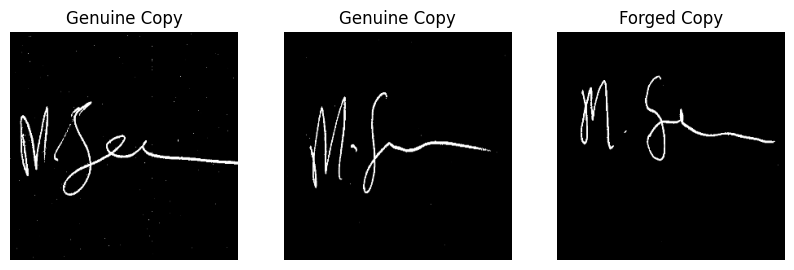

In [ ]:
visualize_sample_signature()

In [ ]:
def generate_batch(orig_groups, forg_groups, batch_size = 32):
  while True:
        orig_pairs = []
        forg_pairs = []
        gen_gen_labels = []
        gen_for_labels = []
        all_pairs = []
        all_labels = []

        for orig, forg in zip(orig_groups, forg_groups):
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            for i in range(len(forg)):
                forg_pairs.extend(list(itertools.product(orig[i:i+1], random.sample(forg, 12))))

        gen_gen_labels = [1]*len(orig_pairs)
        gen_for_labels = [0]*len(forg_pairs)

        all_pairs = orig_pairs + forg_pairs
        all_labels = gen_gen_labels + gen_for_labels

        all_pairs, all_labels = shuffle(all_pairs, all_labels)

        k = 0
        pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
        targets=np.zeros((batch_size,))
        for ix, pair in enumerate(all_pairs):
            img1 = preprocess(pair[0])
            img2 = preprocess(pair[1])
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield tuple(pairs), targets
                k = 0
                pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
                targets=np.zeros((batch_size,))

In [ ]:
orig_pairs = []
forg_pairs = []
gen_gen_labels = []
gen_for_labels = []
all_pairs = []
all_labels = []

for orig, forg in zip(orig_train, forg_train):
    orig_pairs.extend(list(itertools.combinations(orig, 2)))
    for i in range(len(forg)):
        forg_pairs.extend(list(itertools.product(orig[i:i+1], random.sample(forg, 12))))

gen_gen_labels = [1]*len(orig_pairs)
gen_for_labels = [0]*len(forg_pairs)

all_pairs = orig_pairs + forg_pairs
all_labels = gen_gen_labels + gen_for_labels

all_pairs, all_labels = shuffle(all_pairs, all_labels)

len(all_pairs), len(all_labels)

(24816, 24816)

In [ ]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [ ]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [ ]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [ ]:
def create_base_network_signet(input_shape):
    '''Base Siamese Network'''

    seq = Sequential()
    seq.add(Conv2D(96, kernel_size=(11, 11), activation='relu', name='conv1_1', strides=4, input_shape= input_shape,
                        kernel_initializer='glorot_uniform', data_format='channels_last')) # Assuming 'tf' dim_ordering means channels_last
    seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9)) # mode argument is deprecated
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(ZeroPadding2D((2, 2), data_format='channels_last')) # Changed dim_ordering to data_format

    seq.add(Conv2D(256, kernel_size=(5, 5), activation='relu', name='conv2_1', strides=1, kernel_initializer='glorot_uniform',  data_format='channels_last')) # Changed init and dim_ordering
    seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9)) # mode argument is deprecated
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(ZeroPadding2D((1, 1), data_format='channels_last')) # Changed dim_ordering to data_format

    seq.add(Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv3_1', strides=1, kernel_initializer='glorot_uniform',  data_format='channels_last')) # Changed init and dim_ordering
    seq.add(ZeroPadding2D((1, 1), data_format='channels_last')) # Changed dim_ordering to data_format

    seq.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv3_2', strides=1, kernel_initializer='glorot_uniform', data_format='channels_last'))  # Changed init and dim_ordering
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(Flatten(name='flatten'))
    seq.add(Dense(1024, kernel_regularizer=l2(0.0005), activation='relu', kernel_initializer='glorot_uniform')) # Changed W_regularizer to kernel_regularizer and init to kernel_initializer
    seq.add(Dropout(0.5))

    seq.add(Dense(128, kernel_regularizer=l2(0.0005), activation='relu', kernel_initializer='glorot_uniform')) # softmax changed to relu, Changed W_regularizer to kernel_regularizer and init to kernel_initializer

    return seq

In [ ]:
input_shape=(img_h, img_w, 1)

In [ ]:
# network definition
base_network = create_base_network_signet(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model(inputs=[input_a, input_b], outputs=distance)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
batch_sz = 128
num_train_samples = 24816
num_val_samples = 3384
num_test_samples = 2820
num_train_samples, num_val_samples, num_test_samples

(24816, 3384, 2820)

In [ ]:
rms = RMSprop(learning_rate=1e-4, rho=0.9, epsilon=1e-08)
model.compile(loss=contrastive_loss, optimizer=rms)

In [ ]:
callbacks = [
    EarlyStopping(patience=12, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('net-{epoch:03d}.weights.h5', verbose=1, save_weights_only=True)
]

In [ ]:
results = model.fit(generate_batch(orig_train, forg_train, batch_sz),
                              steps_per_epoch = num_train_samples//batch_sz,
                              epochs = 100,
                              validation_data = generate_batch(orig_val, forg_val, batch_sz),
                              validation_steps = num_val_samples//batch_sz,
                              callbacks = callbacks)

Epoch 1/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 20.5633
Epoch 1: saving model to /content/Weights/net-001.weights.h5
193/193 ━━━━━━━━━━━━━━━━━━━━ 271s 1s/step - loss: 20.4820 - val_loss: 1.1043 - learning_rate: 1.0000e-04
Epoch 2/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 1.0354
Epoch 2: saving model to /content/Weights/net-002.weights.h5
193/193 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - loss: 1.0349 - val_loss: 0.7994 - learning_rate: 1.0000e-04
Epoch 3/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.7184
Epoch 3: saving model to /content/Weights/net-003.weights.h5
193/193 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - loss: 0.7181 - val_loss: 0.6020 - learning_rate: 1.0000e-04
Epoch 4/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.5126
Epoch 4: saving model to /content/Weights/net-004.weights.h5
193/193 ━━━━━━━━━━━━━━━━━━━━ 238s 1s/step - loss: 0.5124 - val_loss: 0.4487 - learning_rate: 1.0000e-04
Epoch 5/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.3621
Epo

KeyboardInterrupt: 

KeyboardInterrupt: 

In [ ]:
def compute_accuracy_roc(predictions, labels):
    '''Compute ROC accuracy with a range of thresholds on distances.
    '''
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1)
    ndiff = np.sum(labels == 0)

    step = 0.01
    max_acc = 0
    best_thresh = -1

    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d
        idx2 = predictions.ravel() > d

        tpr = float(np.sum(labels[idx1] == 1)) / nsame
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        acc = 0.5 * (tpr + tnr)
#       print ('ROC', acc, tpr, tnr)

        if (acc > max_acc):
            max_acc, best_thresh = acc, d

    return max_acc, best_thresh

In [ ]:
model.load_weights('net-020.weights.h5')

In [ ]:
test_gen = generate_batch(orig_test, forg_test, 1)
pred, tr_y = [], []
for i in range(num_test_samples):
    (img1, img2), label = next(test_gen)
    tr_y.append(label)
    pred.append(model.predict([img1, img2], verbose=0)[0][0])

In [ ]:
tr_acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y))
tr_acc, threshold

(0.9366847826086957, 1.49)

In [ ]:
def predict_score():
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_point, test_label = next(test_gen)
    img1, img2 = test_point[0], test_point[1]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")

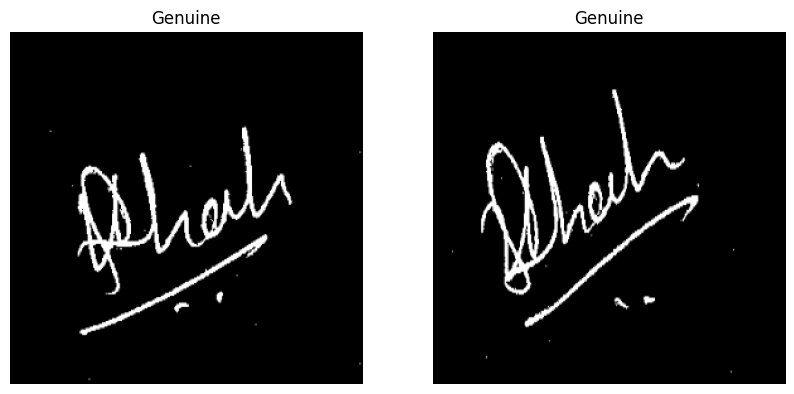

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Difference Score =  1.4749193
Its a Genuine Signature


In [ ]:
predict_score()

In [ ]:
for i in range(len(pred)):
  if pred[i] > threshold:
    pred[i] = 0
  else:
    pred[i] = 1

print(pred)

[0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 

In [ ]:
print(np.array(tr_y).shape)

(2820, 1)


In [ ]:
pred = np.array(pred)
pred = pred.reshape((2820, 1))

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

print(f"Accuracy: {accuracy_score(tr_y, pred)}\n")
print(classification_report(tr_y, pred))

Accuracy: 0.9361702127659575

              precision    recall  f1-score   support

         0.0       0.96      0.91      0.94      1440
         1.0       0.91      0.96      0.94      1380

    accuracy                           0.94      2820
   macro avg       0.94      0.94      0.94      2820
weighted avg       0.94      0.94      0.94      2820

